<a href="https://colab.research.google.com/github/KawtharAbuzaid/Facial-Expression-Recognition/blob/main/Facial_Expression_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
from pathlib import Path
import random
from PIL import Image
from torch.optim import Adam
from sklearn.model_selection import KFold

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 95% 115M/121M [00:02<00:00, 58.1MB/s]
100% 121M/121M [00:02<00:00, 56.9MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
data_dir = "/content/images/images"

In [ ]:
from torchvision import transforms as T

In [ ]:
train_augs = T.Compose([
    T.Resize(size=(150, 150)),
    T.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(),
])

val_augs = T.Compose([
    T.Resize(size=(150, 150)),
    T.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(),
])


In [ ]:
train_dir = "/content/images/images/train"
val_dir = "/content/images/images/validation"

In [ ]:
# Use ImageFolder to create datasets

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_augs, # transforms to perform on images
                                  target_transform=None) # transforms to perform on labels

val_data = datasets.ImageFolder(root=val_dir,
                                 transform=val_augs)

print(f"Train data:\n{train_data}\nval data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 28821
    Root location: /content/images/images/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
val data:
Dataset ImageFolder
    Number of datapoints: 7066
    Root location: /content/images/images/validation
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )


In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              shuffle=True) # shuffle the data?

test_loader = DataLoader(dataset=val_data,
                             batch_size=32,
                             shuffle=False) # don't usually need to shuffle testing data

### The model

In [ ]:
from torch.utils.data import DataLoader, Subset

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
import torchvision.models as models
from torchvision.models import efficientnet

In [ ]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()


    self.eff_net = models.vgg16(pretrained=True)

    # for param in self.eff_net.parameters():
         #   param.requires_grad = True

    for param in self.eff_net.classifier[:].parameters():
            param.requires_grad = False

    num_features = self.eff_net.classifier[6].in_features
    self.eff_net.classifier[6] = nn.Linear(num_features, 7)

  def forward(self, images, labels = None):
    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)

      return logits, loss

    return logits

In [ ]:
model = FaceModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s] 


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.to(device)

FaceModel(
  (eff_net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
l2_loss = nn.L1Loss()

In [ ]:
def train_fn(model, dataloader, optimizer, current_epo):

  model.train()
  total_loss = 0
  total_acc = 0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(epoch))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, labels)

    # Calculate L2 regularization
    l2_regularization = torch.tensor(0., device=device)
    for param in model.parameters():
             l2_regularization += torch.norm(param, 2)

    # Add L2 regularization to the loss
    loss += 0.5 * l2_lambda * l2_regularization

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)


In [ ]:
def eval_fn(model, dataloader, current_epo):

  model.eval()
  total_loss = 0
  total_acc = 0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TEST]" + str(current_epo + 1) + "/" + str(epoch))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)
l2_lambda = 0.001
best_valid_loss = np.Inf
epochs_no_improve = 0
epoch = 100
patience = 5

In [ ]:
from torch.utils.data import DataLoader, Subset

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Initialize lists to store metrics across all folds
all_train_losses = []
all_train_accuracies = []
all_valid_losses = []
all_valid_accuracies = []

# Iterate over each fold
for fold, (train_indices, valid_indices) in enumerate(kf.split(train_data)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split dataset into train and validation sets for this fold
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    # Create dataloaders for train and validation sets for this fold
    train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
    valid_loader = DataLoader(train_data, batch_size=32, sampler=valid_sampler)

    # Initialize model, optimizer, and other parameters for this fold
    optimizer = Adam(model.parameters(), lr=1e-4)
    best_valid_loss = np.Inf
    epochs_no_improve = 0
    patience = 5  # Number of epochs to wait before stopping if no improvement

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # Train and evaluate the model for this fold
    for epoch in range(epoch):
        train_loss, train_acc = train_fn(model, train_loader, optimizer, epoch)
        valid_loss, valid_acc = eval_fn(model, valid_loader, epoch)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        # Check for improvement in validation loss
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"best-weights-fold-{fold + 1}.pt")
            print("SAVED-BEST-WEIGHTS")
            best_valid_loss = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print("No improvement in validation loss for {} epochs.".format(epochs_no_improve))
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Store metrics for this fold
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_valid_losses.append(valid_losses)
    all_valid_accuracies.append(valid_accuracies)

Fold 1/5


EPOCH[TRAIN]1/0:  35%|███▍      | 250/721 [2:00:02<3:40:45, 28.12s/it, loss=1.803033, acc=0.353125]

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot training and validation accuracies
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


preds, labels = get_predictions_and_labels(model, valid_loader)

cm = confusion_matrix(labels, preds)

print("Confusion Matrix for fold {}: ".format(fold + 1))
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Fold {fold + 1}')
plt.show()

In [ ]:
from collections import Counter

# Assuming train_dataset is your dataset
# Extract labels from the dataset
labels = [label for _, label in train_data]

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the number of samples for each class
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming train_dataset is your dataset

# Extract labels from the dataset
labels = [label for _, label in train_data]

# Count the occurrences of each label
label_counts = Counter(labels)

# Separate the labels and counts for plotting
class_labels = list(label_counts.keys())
sample_counts = list(label_counts.values())

# Plotting the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(class_labels, sample_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(class_labels)
plt.show()


In [ ]:
class_counts = {}
for _, label in train_data:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

print("Original class distribution:", class_counts)

# Step 3: Identify the class to remove (the class with the fewest samples)
class_to_remove = min(class_counts, key=class_counts.get)
print(f"Class to remove: {class_to_remove} with {class_counts[class_to_remove]} samples")

# Step 4: Filter out the samples of the identified class
filtered_indices = [idx for idx, (_, label) in enumerate(train_data) if label != class_to_remove]

# Create a new dataset without the specified class
filtered_dataset = Subset(train_data, filtered_indices)

# Step 5: Verify the new class distribution
filtered_class_counts = {cls: 0 for cls in class_counts.keys() if cls != class_to_remove}
for _, label in filtered_dataset:
    filtered_class_counts[label] += 1

print("Filtered class distribution:", filtered_class_counts)

# Optional: Plot the class distribution for visualization
labels, counts = zip(*filtered_class_counts.items())
plt.bar(labels, counts, color='skyblue', tick_label=[train_data.classes[i] for i in labels])
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Filtered Class Distribution')
plt.show()

SVM model

In [ ]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Define the device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for VGG-16
transform = transforms.Compose([
    transforms.Resize((49, 49)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Load the datasets
train_dataset = ImageFolder(root='/content/images/images/train', transform=transform)
test_dataset = ImageFolder(root='/content/images/images/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Load and modify the pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)
vgg16_features = torch.nn.Sequential(*list(vgg16.features.children())[:-1])
vgg16_features.to(device)  # Move the model to the appropriate device
vgg16_features.eval()




# Function to extract features
def extract_features(data_loader):
    features = []
    labels = []

    for images, labels_batch in data_loader:
        images, labels_batch = images.to(device), labels_batch.to(device)
        with torch.no_grad():
            outputs = vgg16_features(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features
            features.append(outputs.cpu().numpy())  # Move tensors back to CPU for sklearn compatibility
            labels.append(labels_batch.cpu().numpy())

        return np.concatenate(features), np.concatenate(labels)



# Extract features from train and test datasets
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)



# Initialize and train the SVM classifier
clf = SVC(kernel='linear')
clf.fit(train_features, train_labels)

# Make predictions on the test set
y_pred_test = clf.predict(test_features)

# Calculate and print the accuracy on the test set
accuracy_test = accuracy_score(test_labels, y_pred_test)
print("Test Accuracy (SVM with VGG-16 features):", accuracy_test)


train_dir = "/content/images/images/train"
val_dir = "/content/images/images/validation"

from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import numpy as np

# Assuming clf is your trained SVM model and test_features, test_labels are ready
y_pred = clf.predict(test_features)

# Generate the classification report
unique_labels = np.unique(test_labels)
target_names = unique_labels.tolist()
target_names = unique_labels.astype(str).tolist()
report = classification_report(test_labels, y_pred, labels=unique_labels, target_names=target_names)
print("Classification Report:\n", report)

# Test accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Test Accuracy:", accuracy)

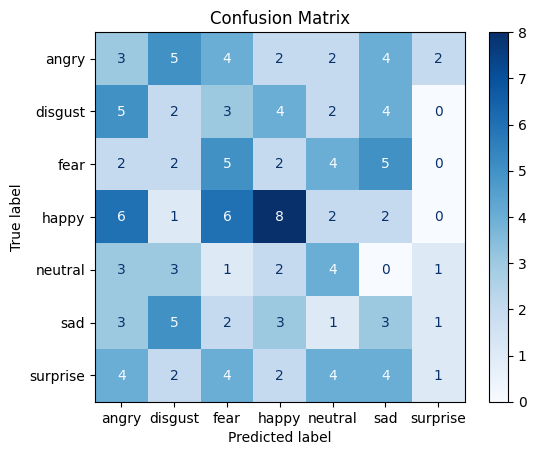

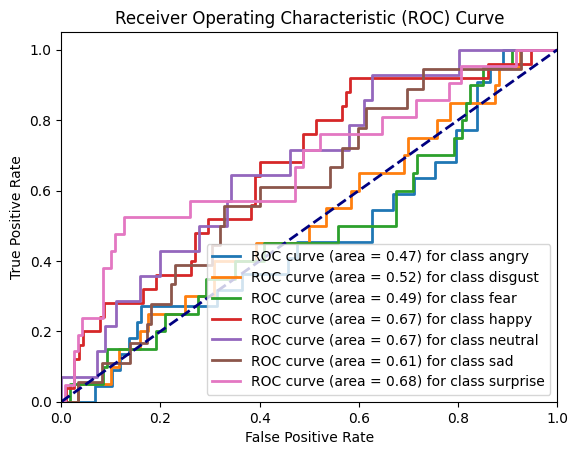

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Define the categories
categories = ['happy', 'angry', 'surprise', 'fear', 'neutral', 'sad', 'disgust']

# Initialize lists to hold the data and labels
data = []
labels = []

# Load and preprocess images
image_size = (64, 64)

for category in categories:
    category_dir = os.path.join('images/images/train', category)
    for file_name in os.listdir(category_dir)[:100]:  # Limiting to 100 images per category for initial analysis
        file_path = os.path.join(category_dir, file_name)
        try:
            # Load image
            image = Image.open(file_path)
            # Convert to grayscale
            image = image.convert('L')
            # Resize image
            image = image.resize(image_size)
            # Normalize pixel values
            image = np.array(image) / 255.0
            # Append data and label
            data.append(image)
            labels.append(category)
        except Exception as e:
            print(f'Error loading image {file_path}: {e}')

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape data to include channel dimension
data = data.reshape(data.shape[0], image_size[0], image_size[1], 1)

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_flat, y_train)

# Predict the labels for the testing set
y_pred = svm_model.predict(X_test_flat)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Binarize the labels for ROC curve computation
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute decision function scores
y_score = svm_model.decision_function(X_test_flat)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for all classes
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {label_encoder.classes_[i]}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
